In [30]:
library("dplyr")
library("ggplot2")
library("ggpubr")
library("ggh4x")
library('colorBlindness')

In [31]:
outs_file_cross = read.csv('intermediate_results/olink_scaled_biomarkers_frailty.csv')
outs_file_inc = read.csv('intermediate_results/olink_scaled_biomarkers_mortality.csv')

out_file_all = full_join(outs_file_cross, outs_file_inc)
#outs_file_lin = subset(outs_file_cross, type == "linear" & model == 4 & ! outcome %in% c("bmi.0.0", "smokingyn.0.0", "self_perceived_health"))
#outs_file_risk = subset(outs_file_cross, type == "linear" & model == 4 & outcome %in% c("bmi.0.0", "smokingyn.0.0"))                       
#outs_file_log = subset(outs_file_cross, type == "logistic" & model == 4)

Joining with `by = join_by(outcome, variable, model, N, MH_coef, MH_LL, MH_UL,
MH_p)`


In [32]:
out_file_all = out_file_all %>%
mutate(dataset = case_when(grepl('cmb_met_ffs', variable) ~ 'FFS on cmb + metabolites',
                           grepl('cmb_met', variable) ~ 'Cmb + metabolites',
                           grepl('cmb_ffs', variable) ~ 'FFS on cmb',
                           grepl('cmb', variable) ~ 'Cardiometabolic',
                           grepl('allprot_ffs', variable) ~ 'FFS on 4 protein panels',
                           grepl('allprot', variable) ~ '4 protein panels'),
      trainedout = case_when(grepl('mort|Gadd|PAC', variable) ~ "All-cause mortality",
                             grepl('frailty', variable) ~ "Frailty index",
                            grepl('GDF', variable) ~ "Not"),
      Coef = case_when(outcome == 'FI_0' ~ Coef * 100, 
                       outcome == 'bmi.0.0' ~ Coef * 5,
                       TRUE ~ Coef),
       LL = case_when(outcome == 'FI_0' ~ LL * 100, 
                      outcome == 'bmi.0.0' ~ LL * 5,
                      TRUE ~ LL),
       UL = case_when(outcome == 'FI_0' ~ UL * 100, 
                      outcome == 'bmi.0.0' ~ UL * 5,
                      TRUE ~ UL),
      outcome_name_use = case_when(outcome == "FI_0" ~ "Frailty index (%)",
                               outcome == "max_handgrip" ~ "Handgrip strength (kg)",
                               outcome == 'bmi.0.0' ~ 'BMI (per 5 kg/m^2)',
                               outcome == 'smokingyn.0.0' ~ 'Current smoking',
                               outcome == 'hbp.0.0' ~ "High blood pressure",
                               outcome == 'cancer_prev' ~ 'Prevalent cancer',
                               outcome == 'CVD_prev' ~ 'Prevalent CVD',
                               outcome == 'poor_health' ~ 'Self-rated Poor Health',
                               outcome == "died" ~ "All-cause mortality",
                               outcome == "cancer_inc" ~ "Incident cancer",
                               outcome == "CVD_inc" ~ "Incident CVD"),
       datasetname = case_when(grepl('coefs', variable) ~ "Elastic Net",
                               grepl('nn', variable) ~ "Feedforward neural network"),
       variable2 = paste0(dataset, "_", trainedout), 
       compare_var = recode(variable, 
                     aa_coefs_frailty_cmb = 'EN Frailty CMB',
                     aa_coefs_frailty_cmb_ffs = 'EN Frailty CMB_FFS',
                     aa_nn_cmb_frailty = 'FNN Frailty CMB',
                     aa_nn_cmb_ffs_frailty = 'FNN Frailty CMB_FFS',
                     aa_coefs_mort_cmb = 'EN Mortality CMB',
                     aa_coefs_mort_cmb_ffs = 'EN Mortality CMB_FFS',
                     aa_nn_mort_cmb = 'EN Mortality CMB',
                     aa_nn_mort_cmb_ffs = 'EN Mortality CMB_FFS',
                     aa_Gaddprot = "Gadd Mortality protein score",
                     aa_Gaddprotmet = "Gadd Mortality protein metabolite score",
                     aa_PAC = "PAC 8 protein panels",
                     aa_GDF15 = "GDF15",
                     aa_mortScore = "MetaboHealth")
                               
                               
      )
outs_file_lin = subset(out_file_all, type == "linear" & model == 4 & ! outcome %in% c("bmi.0.0", "smokingyn.0.0"))
outs_file_risk = subset(out_file_all, type == "linear" & model == 4 & outcome %in% c("bmi.0.0", "smokingyn.0.0"))                       
outs_file_log = subset(out_file_all, type == "logistic" & model == 4)                           
own_linear = subset(outs_file_lin, grepl('coefs|nn', variable))
own_log = subset(outs_file_log, grepl('coefs|nn', variable))
own_risk = subset(outs_file_risk, grepl('coefs|nn', variable))

outs_file_inc = subset(out_file_all, !is.na(exp.coef.) & model == 3) %>% 
        select(., -c(LL, UL)) %>% 
        rename('HR' = 'exp.coef.','LL' ='exp.coef..lower.95.', 'UL' = 'exp.coef..upper.95.' )
own_inc = subset(outs_file_inc, grepl('coefs|nn', variable) & model == 3)


In [33]:
table(outs_file_inc$model)


 3 
54 

In [34]:
#Set color schemes

colorblind=c(
  "#ffb000",
  "#dc267f",
  "#648fff",
  "#fe6100",
  "#785ef0",
  "#000000")


Tol_light <- c('#BBCC33', '#AAAA00', '#77AADD', '#EE8866', '#EEDD88', '#FFAABB', '#99DDFF', '#44BB99', '#DDDDDD')

extracolorblind= c(
"#f46d43",
"#fdae61",
"#fee090",
"#ffffbf",
"#e0f3f8",
"#abd9e9",
"#74add1",
"#4575b4")

#Tol_light2 <- c('#BBCC33', '#AAAA00', '#77AADD', '#EE8866', '#EEDD88', '#FFAABB', '#99DDFF', '#44BB99', '#DDDDDD','#BFE39A', '#A6B5E3')
Tol_light2 <- c('#B57DC2', '#AAAA00', '#77AADD', '#EE8866', '#EEDD88', '#FFAABB', '#99DDFF', '#44BB99', '#DDDDDD', '#BFE39A', '#A6B5E3', '#D4A4CC', '#117733', '#88CCEE')
Tol_muted <- c('#88CCEE', '#44AA99', '#117733', '#332288', '#DDCC77', '#999933','#CC6677', '#882255', '#AA4499', '#DDDDDD')


In [35]:
length(Tol_light2)

[1] 14

In [36]:
table(own_linear$variable2)


4 protein panels_All-cause mortality       4 protein panels_Frailty index 
                                   4                                    4 
 Cardiometabolic_All-cause mortality        Cardiometabolic_Frailty index 
                                   4                                    4 
      FFS on cmb_All-cause mortality             FFS on cmb_Frailty index 
                                   4                                    4 

In [37]:
table(own_linear$trainedout)


All-cause mortality       Frailty index 
                 12                  12 

In [38]:
df = own_linear
df = subset(df, outcome_name_use %in% 'Frailty index (%)')
df$variable2 = factor(df$variable2, levels = rev(c('4 protein panels_All-cause mortality',
                                                       '4 protein panels_Frailty index',
                                                     'Cardiometabolic_All-cause mortality',
                                                     'Cardiometabolic_Frailty index',
                                                     'FFS on cmb_All-cause mortality',
                                                     'FFS on cmb_Frailty index'
                                                    )))
df <- df %>% arrange(variable2)
df$numrow = 1:nrow(df)
df

type,outcome,variable,model,N,Ncase,Coef,Std.Err,t.value,P,⋯,HR_CI,MH_CI,Concordance,dataset,trainedout,outcome_name_use,datasetname,variable2,compare_var,numrow
<chr>,<chr>,<chr>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<fct>,<chr>,<int>
linear,FI_0,aa_coefs_frailty_cmb_ffs,4,2125,,3.120668,0.001801086,17.32659,5.296055e-63,⋯,NA,NA,NA,FFS on cmb,Frailty index,Frailty index (%),Elastic Net,FFS on cmb_Frailty index,EN Frailty CMB_FFS,1
linear,FI_0,aa_nn_cmb_ffs_frailty,4,2125,,3.377495,0.001751622,19.28210,1.843136e-76,⋯,NA,NA,NA,FFS on cmb,Frailty index,Frailty index (%),Feedforward neural network,FFS on cmb_Frailty index,FNN Frailty CMB_FFS,2
linear,FI_0,aa_coefs_mort_cmb_ffs,4,2125,,2.139203,0.001727557,12.38282,4.730539e-34,⋯,NA,NA,NA,FFS on cmb,All-cause mortality,Frailty index (%),Elastic Net,FFS on cmb_All-cause mortality,EN Mortality CMB_FFS,3
linear,FI_0,aa_nn_cmb_ffs_mort,4,2125,,2.089992,0.001707937,12.23694,2.555595e-33,⋯,NA,NA,NA,FFS on cmb,All-cause mortality,Frailty index (%),Feedforward neural network,FFS on cmb_All-cause mortality,aa_nn_cmb_ffs_mort,4
linear,FI_0,aa_coefs_frailty_cmb,4,2125,,3.519893,0.001733838,20.30116,7.156608e-84,⋯,NA,NA,NA,Cardiometabolic,Frailty index,Frailty index (%),Elastic Net,Cardiometabolic_Frailty index,EN Frailty CMB,5
linear,FI_0,aa_nn_cmb_frailty,4,2125,,3.593985,0.001708973,21.03009,2.497489e-89,⋯,NA,NA,NA,Cardiometabolic,Frailty index,Frailty index (%),Feedforward neural network,Cardiometabolic_Frailty index,FNN Frailty CMB,6
linear,FI_0,aa_coefs_mort_cmb,4,2125,,2.236315,0.001691994,13.21703,2.211664e-38,⋯,NA,NA,NA,Cardiometabolic,All-cause mortality,Frailty index (%),Elastic Net,Cardiometabolic_All-cause mortality,EN Mortality CMB,7
linear,FI_0,aa_nn_cmb_mort,4,2125,,2.090897,0.001668194,12.53390,8.099036e-35,⋯,NA,NA,NA,Cardiometabolic,All-cause mortality,Frailty index (%),Feedforward neural network,Cardiometabolic_All-cause mortality,aa_nn_cmb_mort,8
linear,FI_0,aa_coefs_frailty_allprot,4,2125,,4.082866,0.001640421,24.88914,3.606181e-120,⋯,NA,NA,NA,4 protein panels,Frailty index,Frailty index (%),Elastic Net,4 protein panels_Frailty index,aa_coefs_frailty_allprot,9


In [39]:
plot_function <- function(df, x_name, vline_val, xlabs, levels_outcome, levels_var, plotcol_val, bgcol_val, show_trainedout_labels = FALSE, show_legend = TRUE) {
    df = subset(df, outcome_name_use %in% levels_outcome & variable2 %in% levels_var)
    
    df$variable2 = factor(df$variable2, levels = rev(levels_var))
    df$dataset = factor(df$dataset, levels = rev(c('4 protein panels',
                                                   'Cardiometabolic',
                                                   'FFS on cmb')))
    df$datasetname = factor(df$datasetname, levels = rev(c('Elastic Net', 'Feedforward neural network')))
    df <- df %>% arrange(trainedout, datasetname, variable2)
    df$numrow = 1:nrow(df)
    df['coef'] = df[x_name]  # Save name to coef

    # Get unique trainedout positions and colors
    trainedout_positions <- df %>%
        group_by(trainedout) %>%
        summarize(y_min = min(numrow), y_max = max(numrow)) %>%
        mutate(color = Tol_muted[bgcol_val])  # Assign colors

    # Add background rectangles for trainedout
    plot = ggplot(df, aes(x = coef, y = numrow, xmin = LL, xmax = UL, color = dataset, shape = datasetname)) +
      geom_rect(data = trainedout_positions,
                aes(xmin = -Inf, xmax = Inf, ymin = y_min - 0.5, ymax = y_max + 0.5, fill = color),
                inherit.aes = FALSE, alpha = 0.3) +  # Transparent background
      geom_point(size = 3) +
      geom_errorbarh(height = 0.1) +
      labs(x = xlabs, y = NULL, title = paste("  ", levels_outcome)) +
      geom_vline(xintercept = vline_val, color = 'black', linetype = 'dashed', alpha = 0.5) +
      theme_minimal() +
      scale_color_manual(values = Tol_muted[plotcol_val], "Input\ndata", na.translate = FALSE) +
      scale_fill_identity() +  # Use the fill colors directly
      scale_shape(name = "Training\nmethod") +
      theme(axis.text.y = element_blank(),
            axis.ticks.y = element_blank(),
            text = element_text(size = 18),
           plot.title = element_text(size = 15))
    if(show_legend) {
    plot <-  plot+
      guides(colour = guide_legend(order = 1, nrow = length(plotcol_val), byrow = TRUE, reverse = TRUE),
             shape = guide_legend(order = 2, nrow = length(plotcol_val), byrow = TRUE, reverse=TRUE))}
    if(show_legend == FALSE){
    plot <-  plot+
      guides(colour = 'none', shape = 'none')
    }
    
    # Add trainedout labels if requested
    if (show_trainedout_labels) {
        plot <- plot +
          geom_text(data = trainedout_positions,
                    aes(x = vline_val - (max(df$coef)/8), 
                        y = (y_min + y_max) / 2, label = trainedout),
                    inherit.aes = FALSE, hjust = 0.5, vjust = 0.5, angle = 90, size = 6) +  # Rotate text
          geom_text(data = trainedout_positions,
                    aes(x = vline_val - (max(df$coef)/4), 
                        y = mean(y_min + y_max)/2), 
                    label = "Trained on", inherit.aes = FALSE, 
                    hjust = 0.5, vjust = 0.5, angle = 90, size = 6, fontface = "bold")  # Add "Trained on"
    }

    return(plot)
}


In [40]:
# Create the plots
#Allprot vs cmb
cross = plot_function(df = own_linear, x_name = 'Coef', 
                      vline_val = 0, 
                      xlabs = 'Adjusted Beta', 
                      levels_outcome = "Frailty index (%)",
                      levels_var = c('4 protein panels_All-cause mortality',
                                     'Cardiometabolic_All-cause mortality',
                                     '4 protein panels_Frailty index',
                                     'Cardiometabolic_Frailty index'),
                      plotcol_val = c(4,8), 
                      bgcol_val = c(1,2),
                      show_trainedout_labels = TRUE)

incplot = plot_function(df = own_inc, x_name = 'HR', 
                        vline_val = 1, 
                        xlabs = 'Adjusted HR', 
                        levels_outcome = "All-cause mortality",
                        levels_var = c('4 protein panels_All-cause mortality',
                                       'Cardiometabolic_All-cause mortality',
                                       '4 protein panels_Frailty index',
                                       'Cardiometabolic_Frailty index'),
                        plotcol_val = c(4,8), 
                        bgcol_val = c(1,2),
                        show_trainedout_labels = FALSE)

# Combine the plots
ownresults_fi_mort = ggarrange(cross, incplot, nrow = 1, ncol = 2, 
                               common.legend = TRUE, legend = "bottom", 
                               labels = c("a", "b"), font.label = list(size = 16, face = "bold")) +
                     bgcolor("white")


ggsave(ownresults_fi_mort, filename = "./intermediate_results/Step1_outs_Biomarkers_own.png", width = 9, height = 8, units = 'in', limitsize = F)

#CMB vs CMB_FFS
cross2 = plot_function(df = own_linear, x_name = 'Coef', 
                      vline_val = 0, 
                      xlabs = 'Adjusted Beta', 
                      levels_outcome = "Frailty index (%)",
                      levels_var = c('Cardiometabolic_All-cause mortality',
                                     'FFS on cmb_All-cause mortality',
                                     'Cardiometabolic_Frailty index',
                                     'FFS on cmb_Frailty index'),
                      plotcol_val = c(3,4), 
                      bgcol_val = c(1,2),
                      show_trainedout_labels = TRUE)

incplot2 = plot_function(df = own_inc, x_name = 'HR', 
                        vline_val = 1, 
                        xlabs = 'Adjusted HR', 
                        levels_outcome = "All-cause mortality",
                        levels_var = c('Cardiometabolic_All-cause mortality',
                                     'FFS on cmb_All-cause mortality',
                                     'Cardiometabolic_Frailty index',
                                     'FFS on cmb_Frailty index'),
                      plotcol_val = c(3,4), 
                        bgcol_val = c(1,2),
                        show_trainedout_labels = FALSE)

# Combine the plots
ownresults_fi_mort2 = ggarrange(cross2, incplot2, nrow = 1, ncol = 2, 
                               common.legend = TRUE, legend = "bottom", 
                               labels = c("a", "b"), font.label = list(size = 16, face = "bold")) +
                     bgcolor("white")

ggsave(ownresults_fi_mort2, filename = "./intermediate_results/Step2_outs_Biomarkers_own.png", width = 9, height = 8, units = 'in', limitsize = F)


incnc = plot_function(df = own_inc, x_name = 'HR', 
                        vline_val = 1, 
                        xlabs = 'Adjusted HR', 
                        levels_outcome = "Incident cancer",
                        levels_var = c('4 protein panels_All-cause mortality',
                                       'Cardiometabolic_All-cause mortality',
                                       'FFS on cmb_All-cause mortality',
                                       '4 protein panels_Frailty index',
                                       'Cardiometabolic_Frailty index',
                                       'FFS on cmb_Frailty index'),
                      plotcol_val = c(3,4,8), 
                        bgcol_val = c(1,2),
                        show_legend = TRUE,
                        show_trainedout_labels = FALSE)


incvd = plot_function(df = own_inc, x_name = 'HR', 
                        vline_val = 1, 
                        xlabs = 'Adjusted HR', 
                        levels_outcome = "Incident CVD",
                        levels_var = c('4 protein panels_All-cause mortality',
                                       'Cardiometabolic_All-cause mortality',
                                       'FFS on cmb_All-cause mortality',
                                       '4 protein panels_Frailty index',
                                       'Cardiometabolic_Frailty index',
                                       'FFS on cmb_Frailty index'),
                      plotcol_val = c(3,4,8), 
                        bgcol_val = c(1,2),
                        show_legend = TRUE,
                        show_trainedout_labels = TRUE)

handgrip = plot_function(df = own_linear, x_name = 'Coef', 
                      vline_val = 0, 
                      xlabs = 'Adjusted Beta', 
                      levels_outcome = "Handgrip strength (kg)",
                      levels_var = c('4 protein panels_All-cause mortality',
                                       'Cardiometabolic_All-cause mortality',
                                       'FFS on cmb_All-cause mortality',
                                       '4 protein panels_Frailty index',
                                       'Cardiometabolic_Frailty index',
                                       'FFS on cmb_Frailty index'),
                      plotcol_val = c(3,4,8), 
                        bgcol_val = c(1,2),
                        show_legend = TRUE,
                        show_trainedout_labels = FALSE)

prevcnc = plot_function(df = own_log, x_name = 'Coef', 
                      vline_val = 1, 
                      xlabs = 'Adjusted OR', 
                      levels_outcome = "Prevalent cancer",
                      levels_var = c('4 protein panels_All-cause mortality',
                                       'Cardiometabolic_All-cause mortality',
                                       'FFS on cmb_All-cause mortality',
                                       '4 protein panels_Frailty index',
                                       'Cardiometabolic_Frailty index',
                                       'FFS on cmb_Frailty index'),
                      plotcol_val = c(3,4,8), 
                        bgcol_val = c(1,2),
                        show_legend = TRUE,
                        show_trainedout_labels = FALSE)

prevcvd = plot_function(df = own_log, x_name = 'Coef', 
                      vline_val = 1, 
                      xlabs = 'Adjusted OR', 
                      levels_outcome = "Prevalent CVD",
                      levels_var = c('4 protein panels_All-cause mortality',
                                       'Cardiometabolic_All-cause mortality',
                                       'FFS on cmb_All-cause mortality',
                                       '4 protein panels_Frailty index',
                                       'Cardiometabolic_Frailty index',
                                       'FFS on cmb_Frailty index'),
                      plotcol_val = c(3,4,8), 
                        bgcol_val = c(1,2),
                        show_legend = TRUE,
                        show_trainedout_labels = TRUE)


                                    

selfratedpoor = plot_function(df = own_log, x_name = 'Coef', 
                      vline_val = 1, 
                      xlabs = 'Adjusted OR', 
                      levels_outcome = "Self-rated Poor Health",
                      levels_var = c('4 protein panels_All-cause mortality',
                                       'Cardiometabolic_All-cause mortality',
                                       'FFS on cmb_All-cause mortality',
                                       '4 protein panels_Frailty index',
                                       'Cardiometabolic_Frailty index',
                                       'FFS on cmb_Frailty index'),
                      plotcol_val = c(3,4,8), 
                        bgcol_val = c(1,2),
                        show_legend = TRUE,
                        show_trainedout_labels = FALSE)

highbldprs = plot_function(df = own_log, x_name = 'Coef', 
                      vline_val = 1, 
                      xlabs = 'Adjusted OR', 
                      levels_outcome = "High blood pressure",
                      levels_var = c('4 protein panels_All-cause mortality',
                                       'Cardiometabolic_All-cause mortality',
                                       'FFS on cmb_All-cause mortality',
                                       '4 protein panels_Frailty index',
                                       'Cardiometabolic_Frailty index',
                                       'FFS on cmb_Frailty index'),
                      plotcol_val = c(3,4,8), 
                        bgcol_val = c(1,2),
                        show_legend = TRUE,
                        show_trainedout_labels = TRUE)

cross_smoking = plot_function(df = own_risk, x_name = 'Coef', 
                      vline_val = 0, 
                      xlabs = 'Adjusted Beta', 
                      levels_outcome = "Current smoking",
                      levels_var = c('4 protein panels_All-cause mortality',
                                       'Cardiometabolic_All-cause mortality',
                                       'FFS on cmb_All-cause mortality',
                                       '4 protein panels_Frailty index',
                                       'Cardiometabolic_Frailty index',
                                       'FFS on cmb_Frailty index'),
                      plotcol_val = c(3,4,8), 
                        bgcol_val = c(1,2),
                        show_legend = TRUE,
                        show_trainedout_labels = FALSE)

cross_bmi = plot_function(df = own_risk, x_name = 'Coef', 
                      vline_val = 0, 
                      xlabs = 'Adjusted Beta', 
                      levels_outcome = "BMI (per 5 kg/m^2)",
                      levels_var = c('4 protein panels_All-cause mortality',
                                       'Cardiometabolic_All-cause mortality',
                                       'FFS on cmb_All-cause mortality',
                                       '4 protein panels_Frailty index',
                                       'Cardiometabolic_Frailty index',
                                       'FFS on cmb_Frailty index'),
                      plotcol_val = c(3,4,8), 
                        bgcol_val = c(1,2),
                        show_legend = TRUE,
                        show_trainedout_labels = FALSE)


ownresults_fi_mort3 = ggarrange(incvd, handgrip, highbldprs, selfratedpoor, nrow = 2, ncol = 2, common.legend = TRUE, legend = "bottom", 
                               labels = c("a", "b", "c", "d"), font.label = list(size = 16, face = "bold")) +
                     bgcolor("white")

Warning message in geom_text(data = trainedout_positions, aes(x = vline_val - (max(df$coef)/4), :
“All aesthetics have length 1, but the data has 2 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”
Warning message in geom_text(data = trainedout_positions, aes(x = vline_val - (max(df$coef)/4), :
“All aesthetics have length 1, but the data has 2 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”
Warning message in geom_text(data = trainedout_positions, aes(x = vline_val - (max(df$coef)/4), :
“All aesthetics have length 1, but the data has 2 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”
Warning message in geom_text(data = trainedout_positions, aes(x = vline_val - (max(df$coef)/4), :
“All aesthetics have length 1, but the data has 2 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single ro

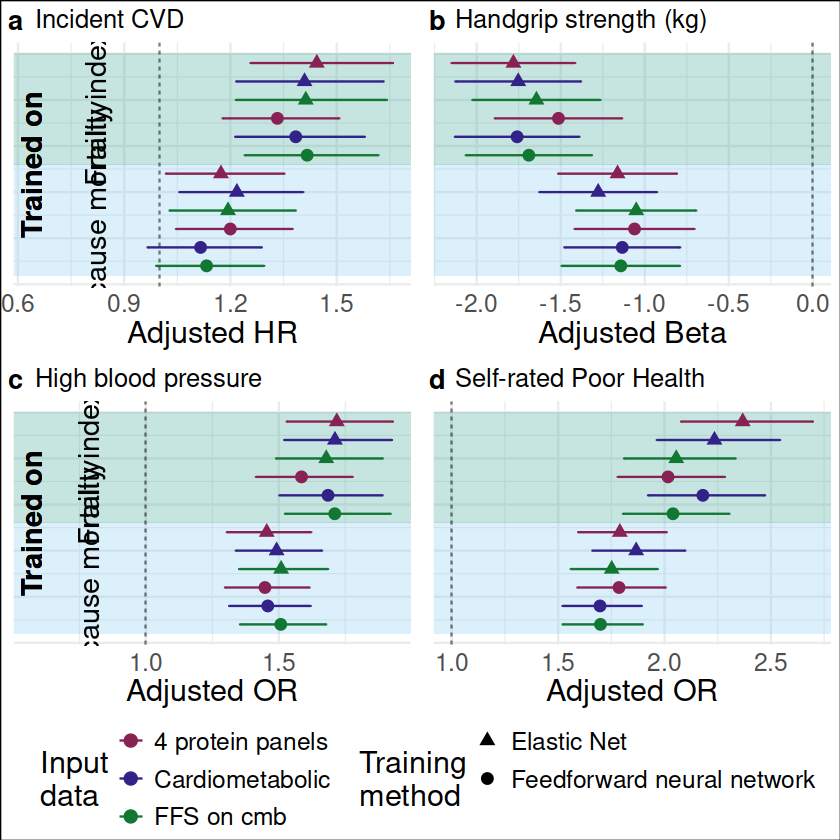

In [41]:
ownresults_fi_mort3
ggsave(ownresults_fi_mort3, filename = "./intermediate_results/Step3_outs_Biomarkers_own.png", width = 12, height = 9, units = 'in', limitsize = F)

In [42]:
plot_function2 <- function(df, x_name, vline_val, xlabs, levels_outcome, levels_var, bgcol_val = c(1,2,3), show_trainedout_labels = FALSE, show_legend = TRUE) {
    df = subset(df, outcome_name_use %in% levels_outcome & compare_var %in% levels_var)

    
    # Apply the order to compare_var
    df$compare_var <- factor(df$compare_var, levels = rev(levels_var))
    
    df <- df %>% arrange(compare_var)
    df$numrow <- 1:nrow(df)
    df['coef'] <- df[[x_name]]  # Save the specified column as coef

    ## Get unique trainedout positions and colors
    trainedout_positions <- df %>%
        group_by(trainedout) %>%
        summarize(y_min = min(numrow), y_max = max(numrow)) %>%
        mutate(color = Tol_muted[bgcol_val])  # Assign colors

    # Plot setup
    plot <- ggplot(df, aes(x = coef, y = numrow, xmin = LL, xmax = UL, color = compare_var)) +
      geom_rect(data = trainedout_positions,
                aes(xmin = -Inf, xmax = Inf, ymin = y_min - 0.5, ymax = y_max + 0.5, fill = color),
                inherit.aes = FALSE, alpha = 0.3) +  # Transparent background
      geom_point(size = 3) +
      geom_errorbarh(height = 0.1) +
      labs(x = xlabs, y = NULL, title = paste("  ", levels_outcome)) +
      geom_vline(xintercept = vline_val, color = 'black', linetype = 'dashed', alpha = 0.5) +
      theme_minimal() +
      scale_color_discrete(name = "Biomarker", na.translate = FALSE) +
      scale_fill_identity() +  # Use the fill colors directly
      scale_shape(name = "Variable") +
      theme(axis.text.y = element_blank(),
            axis.ticks.y = element_blank(),
            text = element_text(size = 18),
           plot.title = element_text(size = 12))

    if (show_legend) {
      plot <- plot +
        guides(
          colour = guide_legend(order = 1, nrow = length(levels_var), byrow = TRUE, reverse = TRUE)
        )
    } else {
      plot <- plot +
        guides(colour = 'none')
    }
    
     # Add trainedout labels if requested
    if (show_trainedout_labels) {
        plot <- plot +
          geom_text(data = trainedout_positions,
                    aes(x = vline_val - (max(df$coef)/8), 
                        y = (y_min + y_max) / 2, label = trainedout),
                    inherit.aes = FALSE, hjust = 0.5, vjust = 0.5, angle = 90, size = 6) +  # Rotate text
          geom_text(data = trainedout_positions,
                    aes(x = vline_val - (max(df$coef)/4), 
                        y = mean(y_min + y_max)/2), 
                    label = "Trained on", inherit.aes = FALSE, 
                    hjust = 0.5, vjust = 0.5, angle = 90, size = 6, fontface = "bold")  # Add "Trained on"
    }

    return(plot)
}


In [43]:
compare_linear = subset(outs_file_lin, grepl('cmb|Gadd|mortScore|GDF|PAC', variable))
compare_log = subset(outs_file_log, grepl('cmb|Gadd|mortScore|GDF|PAC', variable))
compare_risk = subset(outs_file_risk, grepl('cmb|Gadd|mortScore|GDF|PAC', variable))
compare_inc = subset(outs_file_inc, grepl('cmb|Gadd|mortScore|GDF|PAC', variable))

In [48]:
# Define the order of levels
order <- c(
  'EN Frailty CMB_FFS',
  'EN Mortality CMB_FFS',
  "PAC 8 protein panels",
  'Gadd Mortality protein score',
  'Gadd Mortality protein metabolite score',
  'MetaboHealth',
  'GDF15'
)

# Background color values
bgcol_val <- c(1, 2, 3)

# Wrapper function for creating plots
create_plot <- function(df, x_name, vline_val, xlabs, outcome, show_labels = FALSE, show_legend = FALSE) {
  plot_function2(
    df = df,
    x_name = x_name,
    vline_val = vline_val,
    xlabs = xlabs,
    levels_outcome = outcome,
    levels_var = order,
    bgcol_val = bgcol_val,
    show_trainedout_labels = show_labels,
    show_legend = show_legend
  )
}

# Create individual plots
frailtyplot <- create_plot(compare_linear, "Coef", 0, "Adjusted Beta", "Frailty index (%)", TRUE, TRUE)
mortcompare <- create_plot(compare_inc, "HR", 1, "Adjusted HR", "All-cause mortality", FALSE, FALSE)
compareinccnc <- create_plot(compare_inc, "HR", 1, "Adjusted HR", "Incident cancer", FALSE, FALSE)
compareincvd <- create_plot(compare_inc, "HR", 1, "Adjusted HR", "Incident CVD", FALSE, FALSE)
comparehandgrip <- create_plot(compare_linear, "Coef", 0, "Adjusted Beta", "Handgrip strength (kg)", FALSE, FALSE)
compareprevcnc <- create_plot(compare_log, "Coef", 1, "Adjusted OR", "Prevalent cancer", FALSE, FALSE)
compareprevcvd <- create_plot(compare_log, "Coef", 1, "Adjusted OR", "Prevalent CVD", FALSE, FALSE)
cmprselfratedpoor <- create_plot(compare_log, "Coef", 1, "Adjusted OR", "Self-rated Poor Health", TRUE, FALSE)
cmprhighbldprs <- create_plot(compare_log, "Coef", 1, "Adjusted OR", "High blood pressure", TRUE, FALSE)
cmpr_smoking <- create_plot(compare_risk, "Coef", 0, "Adjusted Beta", "Current smoking", FALSE, FALSE)
cmpr_bmi <- create_plot(compare_risk, "Coef", 0, "Adjusted Beta", "BMI (per 5 kg/m^2)", FALSE, FALSE)



Warning message in geom_text(data = trainedout_positions, aes(x = vline_val - (max(df$coef)/4), :
“All aesthetics have length 1, but the data has 3 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”
Warning message in geom_text(data = trainedout_positions, aes(x = vline_val - (max(df$coef)/4), :
“All aesthetics have length 1, but the data has 3 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”
Warning message in geom_text(data = trainedout_positions, aes(x = vline_val - (max(df$coef)/4), :
“All aesthetics have length 1, but the data has 3 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”


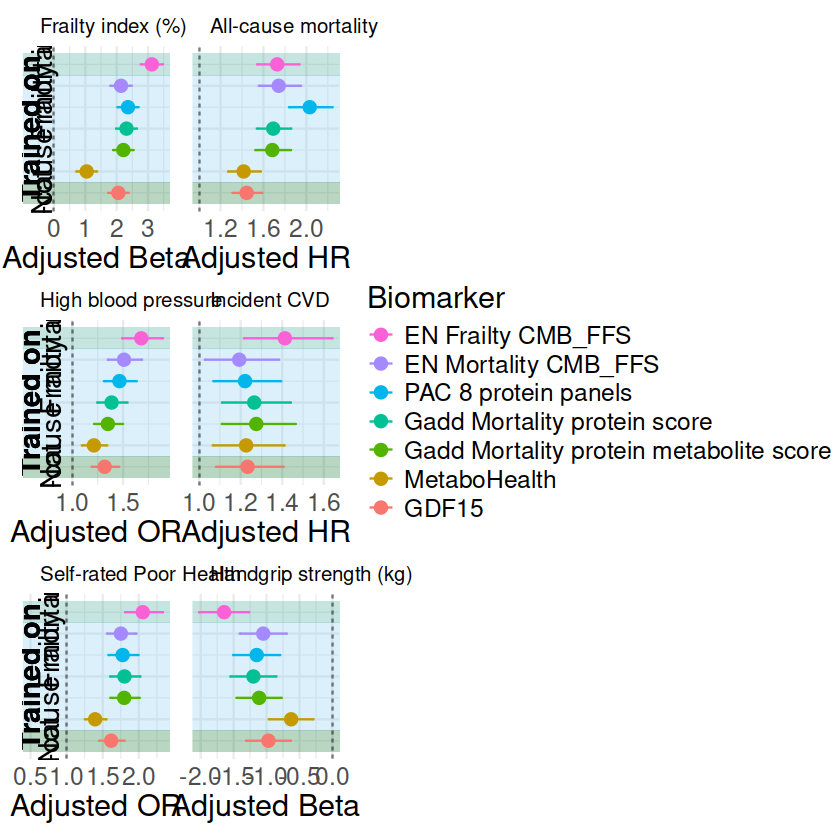

In [49]:
# Arrange all plots

library(patchwork)

# Left column
left_column <- (
  (frailtyplot | mortcompare) / 
 (cmprhighbldprs | compareincvd )/
 (cmprselfratedpoor | comparehandgrip)
)

# Right column
right_column <- (
  (compareinccnc | compareincvd | comparehandgrip) /
  (compareprevcnc | compareprevcvd | cmprselfratedpoor) 
  
)

# Combine left and right columns
comparesults <- left_column | right_column

# Add shared legend
comparesults <- left_column + 
  plot_layout(guides = "collect") & 
  theme(legend.position = "right")

# Display the final layout
print(comparesults)


In [ ]:
ggsave(comparesults, filename = "./intermediate_results/Fig_Compare.png", width = 16, height =  24, units = "in", limitsize = F)


Warning message in geom_text(data = trainedout_positions, aes(x = vline_val - (max(df$coef)/4), :
“All aesthetics have length 1, but the data has 3 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”
Warning message in geom_text(data = trainedout_positions, aes(x = vline_val - (max(df$coef)/4), :
“All aesthetics have length 1, but the data has 3 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”
Warning message in geom_text(data = trainedout_positions, aes(x = vline_val - (max(df$coef)/4), :
“All aesthetics have length 1, but the data has 3 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”


In [129]:
comparehandgrip = plot_function(df = compare_linear, x_name = 'Coef', 
                      vline_val = 0, 
                      xlabs = 'Adjusted Beta', 
                      levels_outcome = "Handgrip strength (kg)",
                      levels_var = order,
                      plotcol_val = 4:(length(order)+3),
                      bgcol_val = c(1,2,3),
                      show_trainedout_labels = TRUE,
                      show_legend = FALSE
)

ERROR: Error in `$<-.data.frame`(`*tmp*`, "numrow", value = 1:0): replacement has 2 rows, data has 0


In [70]:
df = compare_linear
levels_outcome = "Frailty index (%)"
levels_var = order
df = subset(df, outcome_name_use %in% levels_outcome & compare_var %in% levels_var)
df

,type,outcome,variable,model,N,Ncase,Coef,Std.Err,t.value,P,⋯,MH_HR,HR_CI,MH_CI,Concordance,dataset,trainedout,outcome_name_use,datasetname,variable2,compare_var
,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
5,linear,FI_0,aa_coefs_frailty_cmb_ffs,4,2125,,3.120668,0.001801086,17.326594,5.296055e-63,⋯,NA,NA,NA,NA,FFS on cmb,Frailty index,Frailty index (%),Elastic Net,FFS on cmb_Frailty index,EN Frailty CMB_FFS
17,linear,FI_0,aa_coefs_frailty_cmb,4,2125,,3.519893,0.001733838,20.301161,7.156608e-84,⋯,NA,NA,NA,NA,Cardiometabolic,Frailty index,Frailty index (%),Elastic Net,Cardiometabolic_Frailty index,EN Frailty CMB
53,linear,FI_0,aa_coefs_mort_cmb,4,2125,,2.236315,0.001691994,13.217034,2.211664e-38,⋯,NA,NA,NA,NA,Cardiometabolic,All-cause mortality,Frailty index (%),Elastic Net,Cardiometabolic_All-cause mortality,EN Mortality CMB
65,linear,FI_0,aa_coefs_mort_cmb_ffs,4,2125,,2.139203,0.001727557,12.382817,4.730539e-34,⋯,NA,NA,NA,NA,FFS on cmb,All-cause mortality,Frailty index (%),Elastic Net,FFS on cmb_All-cause mortality,EN Mortality CMB_FFS
125,linear,FI_0,aa_nn_cmb_frailty,4,2125,,3.630473,0.001709618,21.235583,6.859970e-91,⋯,NA,NA,NA,NA,Cardiometabolic,Frailty index,Frailty index (%),Feedforward neural network,Cardiometabolic_Frailty index,FNN Frailty CMB
137,linear,FI_0,aa_nn_cmb_ffs_frailty,4,2125,,3.377495,0.001751622,19.282095,1.843136e-76,⋯,NA,NA,NA,NA,FFS on cmb,Frailty index,Frailty index (%),Feedforward neural network,FFS on cmb_Frailty index,FNN Frailty CMB_FFS
149,linear,FI_0,aa_Gaddprot,4,2125,,2.313639,0.001676768,13.798200,1.544605e-41,⋯,NA,NA,NA,NA,NA,All-cause mortality,Frailty index (%),NA,NA_All-cause mortality,Gadd Mortality protein score
161,linear,FI_0,aa_Gaddprotmet,4,2125,,2.213304,0.001653153,13.388381,2.666862e-39,⋯,NA,NA,NA,NA,NA,All-cause mortality,Frailty index (%),NA,NA_All-cause mortality,Gadd Mortality protein metabolite score
185,linear,FI_0,aa_PAC,4,2125,,2.360315,0.001709786,13.804742,1.421179e-41,⋯,NA,NA,NA,NA,NA,All-cause mortality,Frailty index (%),NA,NA_All-cause mortality,PAC 8 protein panels


In [41]:
#Function to compare biomarkers of different papers
compare_plot_function <- function(df, x_name, vline_val, col_val, xlabs, levels_outcome, levels_biomarkers) {
    df$outcome_name_use = factor(df$outcome_name_use, levels = levels_outcome)
    
    df$compare_var = factor(df$compare_var, levels = levels_biomarkers)
    # Arrange to make sure order is correct
    df <- df %>% arrange(compare_var)
    
    # Create colored boxes for strips
    strip_make <- strip_themed(
        background_y = elem_list_rect(fill = Tol_light2[col_val], linetype = "solid", color = "black", linewidth = 1)
    )
    df['coef'] = df[x_name] # Save name to coef otherwise won't work
    
    plot = ggplot(df, aes(x = coef, y = compare_var, xmin = LL, xmax = UL, color = compare_var, shape = trainedout)) +
        geom_point(size = 3) +
        geom_errorbarh(height = 0.1) +
        facet_grid2(outcome_name_use ~ ., scales = "free_y", space = "free", switch = "y", strip = strip_make) +
        labs(x = xlabs, y = NULL) +
        geom_vline(xintercept = vline_val, color = 'black', linetype = 'dashed', alpha = 0.5) +
        theme_minimal() +
        scale_color_manual(
            values = c(Tol_muted, 'black'), "Biomarker",
            labels = levels_biomarkers, 
            na.translate = FALSE
        ) +
        scale_shape(name = "Training\noutput") +
        theme(
            axis.text.y = element_blank(),  # Remove y-axis labels
            axis.ticks.y = element_blank(),  # Remove y-axis ticks
            text = element_text(size = 18)
        ) +
        guides(
            colour = guide_legend(order = 1, nrow = 9, byrow = TRUE, reverse = TRUE),
            shape = guide_legend(order = 2, nrow = 3, byrow = TRUE)
        )
    
    return(plot)
}


In [42]:
order = rev(c(
  'EN Frailty CMB',
  'EN Frailty CMB_FFS',
  'FNN Frailty CMB',
  'FNN Frailty CMB_FFS',
  'EN Mortality CMB',
  'EN Mortality CMB_FFS',
  'FNN Mortality CMB',
  'FNN Mortality CMB_FFS',
   "PAC 8 protein panels",
  'Gadd Mortality protein score',
  'Gadd Mortality protein metabolite score',
  'MetaboHealth',
  'GDF15'
))
cross_compare = compare_plot_function(df = compare_linear, x_name = 'Coef', 
                      vline_val = 0, col_val = c(1,2), 
                      xlabs = 'Adjusted Beta', 
                      levels_outcome = c("Frailty index (%)", "Handgrip strength (kg)"), levels_biomarkers = order)

ggsave(cross_compare, filename = "./intermediate_results/Cross_sectional_Compare.png", width = 16, height =  12, units = "in", limitsize = F)

#Linear risk factor (biomarker outcome variable)
risk_compare = compare_plot_function(df = compare_risk, x_name = 'Coef', 
                      vline_val = 0, col_val = c(3,4), 
                      xlabs = 'Adjusted Beta', 
                      levels_outcome = c("Current smoking", "BMI (per 5 kg/m^2)"), levels_biomarkers = order)
                                  
ggsave(risk_compare, filename = "./intermediate_results/Riskfactor_Compare.png", width = 16, height =  12, units = "in", limitsize = F)

#Logistic crossectional
log_compare = compare_plot_function(df = compare_log, x_name = 'Coef', 
                      vline_val = 1, col_val = c(5,7,9,10,11), 
                      xlabs = 'Adjusted OR', 
                      levels_outcome = c("Prevalent cancer",
                                        "Prevalent CVD",
                                        "High blood pressure",
                                        "Self-rated Poor Health"), levels_biomarkers = order)
                                  
ggsave(log_compare, filename = "./intermediate_results/Logist_Compare.png", width = 16, height =  12, units = "in", limitsize = F)

#Incident outcomes
inc_compare = compare_plot_function(df = compare_inc, x_name = 'HR', 
                      vline_val = 1, col_val = c(12, 5, 7), 
                      xlabs = 'Adjusted HR', 
                      levels_outcome = c("All-cause mortality",
                                         "Incident cancer",
                                        "Incident CVD"), levels_biomarkers = order)
                                  
ggsave(inc_compare, filename = "./intermediate_results/Inc_Compare.png", width = 16, height =  12, units = "in", limitsize = F)



Warning message:
“Removed 6 rows containing missing values or values outside the scale range (`geom_point()`).”
Warning message:
“Removed 6 rows containing missing values or values outside the scale range (`geom_point()`).”
Warning message:
“Removed 12 rows containing missing values or values outside the scale range (`geom_point()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range (`geom_point()`).”


Warning message:
“Removed 6 rows containing missing values or values outside the scale range (`geom_point()`).”


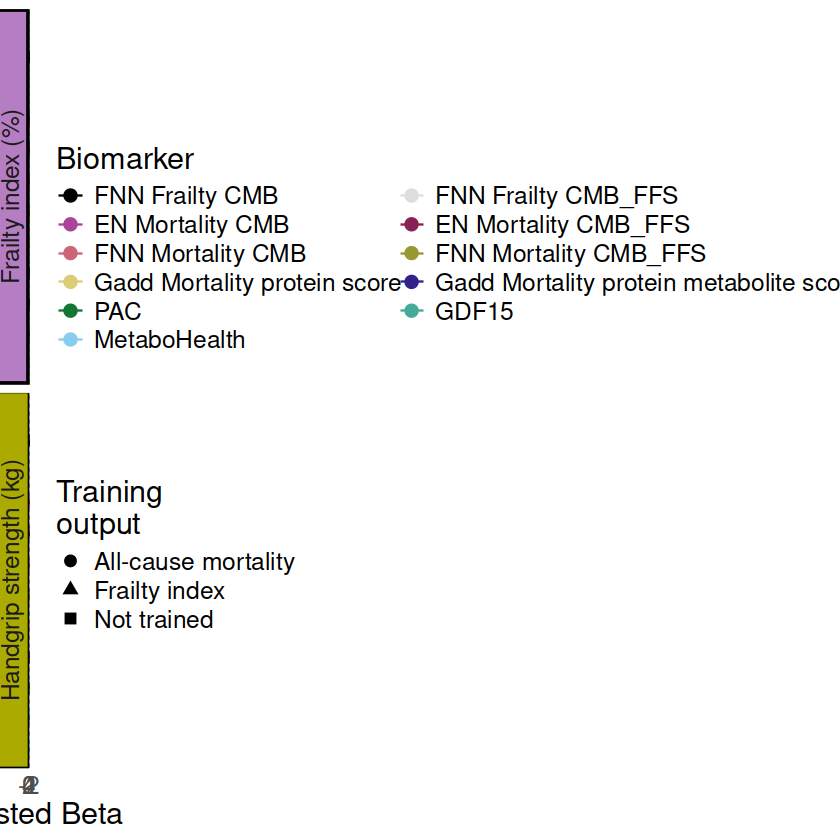

In [43]:
cross_compare

Warning message:
“Removed 6 rows containing missing values or values outside the scale range (`geom_point()`).”
Warning message:
“Removed 6 rows containing missing values or values outside the scale range (`geom_point()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range (`geom_point()`).”
Warning message:
“Removed 12 rows containing missing values or values outside the scale range (`geom_point()`).”
Warning message:
“Removed 6 rows containing missing values or values outside the scale range (`geom_point()`).”


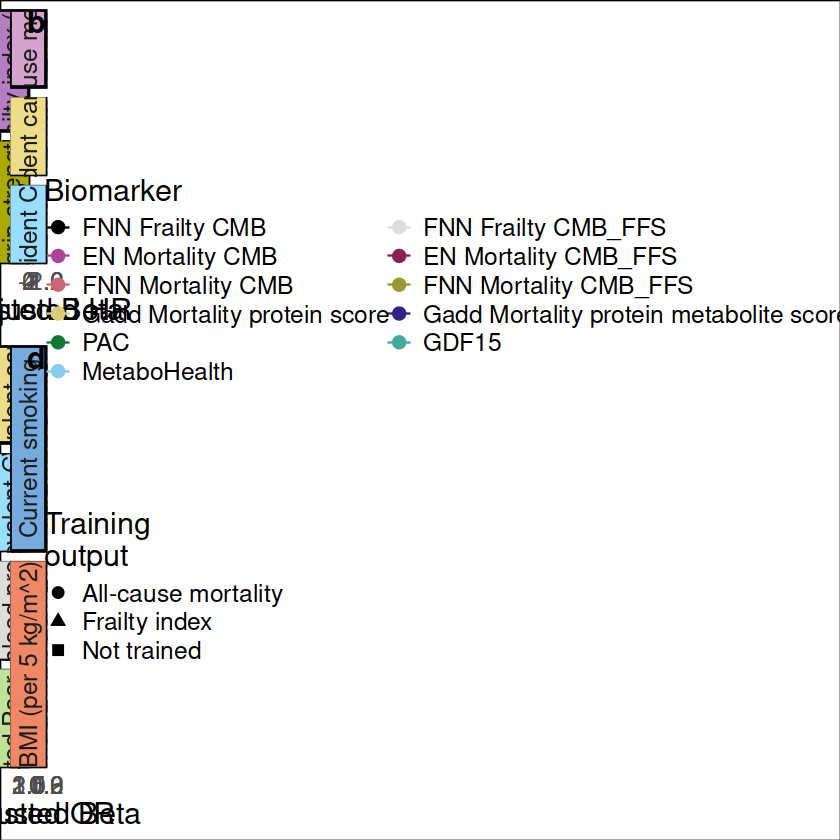

In [44]:
allcompareresults = ggarrange(cross_compare, inc_compare, log_compare, risk_compare, nrow = 2, ncol=2, common.legend = T, legend = "right", heights = c(1,1.5), labels = c("a", "b", "c", "d"), font.label = list(size = 18, face = "bold"))+ bgcolor("white")
ggsave(allcompareresults, filename = "./intermediate_results/All_outs_Biomarkers_compare.png", width = 15, height =  15, units = "in", limitsize = F)
allcompareresults